<a href="https://colab.research.google.com/github/saad-jameel/DL_Projects/blob/main/363520_SaadJameel_DL_Project2_Semantic_Segmentation_UNET.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Import Libraries**

In [ ]:
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
import cv2 
import matplotlib.pyplot as plt
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from os import getcwd
import os
import sys
from PIL import Image


# **Mounting Drive & Reading File**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
PATH = "/content/drive/MyDrive/DL Project Datasets/Segmentation Datasets/Underwater Semantic Segmentation"

train_img_names = os.listdir(os.path.join(PATH ,"train_val/images"))
print(train_img_names[0])
print(len(train_img_names))

test_img_names = os.listdir(os.path.join(PATH ,"TEST/images"))
print(test_img_names[0])
print(len(test_img_names))



f_r_1692_.jpg
1525
d_r_345_.jpg
110


# **Naming Test and Train Data**

In [ ]:
train_masks_names = []
test_masks_names = []

for string in train_img_names:
  string = string[:-3]+"bmp"
  #print(string)
  train_masks_names.append(string)

for string in test_img_names:
  string = string[:-3]+"bmp"
  #print(string)
  test_masks_names.append(string)

for i in range (3):
  print("Train image name:",train_img_names[i])
  print("Train mask name:",train_masks_names[i])
  print("Test image name:",test_img_names[i])
  print("Test mask name:",test_masks_names[i])

Train image name: f_r_1692_.jpg
Train mask name: f_r_1692_.bmp
Test image name: d_r_345_.jpg
Test mask name: d_r_345_.bmp
Train image name: f_r_1645_.jpg
Train mask name: f_r_1645_.bmp
Test image name: d_r_300_.jpg
Test mask name: d_r_300_.bmp
Train image name: f_r_160_.jpg
Train mask name: f_r_160_.bmp
Test image name: d_r_196_.jpg
Test mask name: d_r_196_.bmp


# **Training & Test Data Creation**

In [ ]:
train_images = []
train_masks = []

for index in range(len(train_img_names)):
   image = tf.io.read_file(os.path.join(PATH,"train_val", "images",train_img_names[index]))
   image = tf.image.decode_png(image, channels=3)
   image = tf.image.convert_image_dtype(image, tf.float32)
   image = np.asarray(image)
   image = tf.image.resize(image,(256,256),method ='nearest')
   train_images.append(image)

   mask = tf.io.read_file(os.path.join(PATH,"train_val", "masks",train_masks_names[index]))
   mask = tf.image.decode_bmp(mask, channels=3)
   mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
   mask = np.asarray(mask)
   mask = tf.image.resize(mask,(256,256),method ='nearest')
   train_masks.append(mask)
   print(index)

print("Number of training images:",len(train_images))
print("Number of training masks:",len(train_masks))

In [ ]:
test_images = []
test_masks = []

for index in range(len(test_img_names)):
   image = tf.io.read_file(os.path.join(PATH,"TEST", "images",test_img_names[index]))
   image = tf.image.decode_png(image, channels=3)
   image = tf.image.convert_image_dtype(image, tf.float32)
   image = np.asarray(image)
   image = tf.image.resize(image,(256,256),method='nearest')
   test_images.append(image)

   mask = tf.io.read_file(os.path.join(PATH,"TEST", "masks",test_masks_names[index]))
   mask = tf.image.decode_bmp(mask, channels=3)
   mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
   mask = np.asarray(mask)
   mask = tf.image.resize(mask,(256,256),method='nearest')
   test_masks.append(mask)
   print(index)

print("Number of testing images:",len(test_images))
print("Number of testing masks:",len(test_masks))

# **Input Tensor**

In [ ]:
train_images = np.asarray(train_images)
train_masks = np.asarray(train_masks)
test_images = np.asarray(test_images)
test_masks = np.asarray(test_masks)

train_images = tf.stack(train_images,axis=0)
train_images = tf.stack(train_images,axis=0)
test_images = tf.stack(test_images,axis=0)
test_masks = tf.stack(test_masks,axis=0)

print(train_images.shape), print(train_masks.shape)
print(test_images.shape), print(test_masks.shape)

(1525, 256, 256, 3)
(1525, 256, 256, 1)
(110, 256, 256, 3)
(110, 256, 256, 1)


(None, None)

# **Unique Classes Search in Mask**

In [ ]:
classes, _, _ = tf.unique_with_counts(tf.reshape(train_masks, (-1,)))
print(classes.shape)

(256,)


# **Setting Input Shape for U-Net**

In [ ]:
input_shape = (128, 128, 3)
input = tf.keras.layers.Input(shape=input_shape)

# **Encoding**

In [ ]:
def conv_block(inputs=None, num_filters=32, dropout_prob=0, max_pooling=True):
   

    conv2d = tf.keras.layers.Conv2D(num_filters, 
                  (3, 3),  
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(inputs)
    
    conv2d = tf.keras.layers.Conv2D(num_filters,
                  (3, 3),  
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(conv2d)
    
    if dropout_prob > 0:
        dropout = tf.keras.layers.Dropout(dropout_prob)(conv2d)
    else:
        dropout = conv2d
         
        
    # if max_pooling is True add a MaxPooling2D with 2x2 pool_size
    if max_pooling:
        maxpool = tf.keras.layers.MaxPooling2D((2, 2), strides=2)(dropout)
    else:
        maxpool = dropout

    next_layer = maxpool  
    skip_connection = dropout
    
    return next_layer, skip_connection

# **Decoding**

In [ ]:
def upsampling_block(expansive_input, contractive_input, num_filters=32):
 
    
    upsampled_input = tf.keras.layers.Conv2DTranspose(
                 num_filters,
                 (3, 3),
                 strides=2,
                 padding="same")(expansive_input)
    
    # Merge the previous output and the contractive_input
    merge = tf.keras.layers.concatenate([upsampled_input, contractive_input], axis=3)
    
    conv2d = tf.keras.layers.Conv2D(num_filters, 
                  (3, 3), 
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(merge)
    
    conv2d = tf.keras.layers.Conv2D(num_filters, 
                  (3, 3),
                  activation="relu",
                  padding="same",
                  kernel_initializer="he_normal")(conv2d)
    
    return conv2d

Combining Up & Down Sampling Blocks and Model Creation

In [ ]:
def unet_model(input_size=(None, None, 3), num_filters=32, num_classes=8):

    inputs = tf.keras.layers.Input(input_size)
  
    conv_block_1 = conv_block(inputs=inputs, num_filters=num_filters * 1)
    conv_block_2 = conv_block(inputs=conv_block_1[0], num_filters=num_filters * 2)
    conv_block_3 = conv_block(inputs=conv_block_2[0], num_filters=num_filters * 4)
    conv_block_4 = conv_block(inputs=conv_block_3[0], num_filters=num_filters * 8, dropout_prob=0.3)
    conv_block_5 = conv_block(inputs=conv_block_4[0], num_filters=num_filters * 16, dropout_prob=0.3, max_pooling=False) 
    
    deconv_block_6 = upsampling_block(conv_block_5[0], conv_block_4[1], num_filters * 8)
    deconv_block_7 = upsampling_block(deconv_block_6, conv_block_3[1], num_filters * 4)
    deconv_block_8 = upsampling_block(deconv_block_7, conv_block_2[1], num_filters * 2)
    deconv_block_9 = upsampling_block(deconv_block_8, conv_block_1[1], num_filters * 1)

    conv2d = tf.keras.layers.Conv2D(num_filters,
                 (3, 3),
                 activation="relu",
                 padding="same",
                 kernel_initializer="he_normal")(deconv_block_9)

    outputs = tf.keras.layers.Conv2D(num_classes, 1, padding="same")(conv2d)    
    model = tf.keras.Model(inputs=inputs, outputs=outputs)

    return model

In [ ]:
height, width, channels = train_images[0].shape

unet = unet_model(input_size=(height, width, channels), num_filters=32, num_classes=257)

In [ ]:
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

# **COMPILATION OF MODEL**


In [ ]:
unet.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"]
)

# **U-NET ARCHITECTURE VISUALIZATION**

In [ ]:
!pip install visualkeras

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 992.2/992.2 KB 16.8 MB/s eta 0:00:00


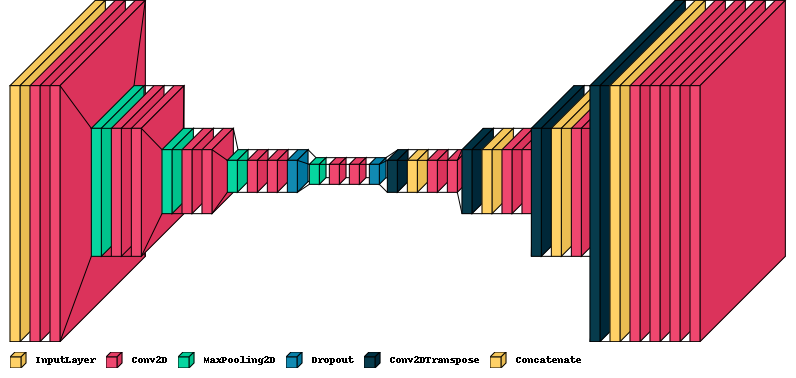

In [ ]:
import visualkeras
visualkeras.layered_view(unet,legend=True,scale_xy=1, scale_z=1,max_z=10 )

In [ ]:
# Callback for stopping tarining

class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.90):
      print("\nReached 90% accuracy so cancelling training!")
      self.model.stop_training = True
callbacks = myCallback()

# **TRAINING**

In [ ]:
BATCH_SIZE = 8
EPOCHS = 30

model_history = unet.fit(
    x=train_images,
    y=train_masks,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=True,
    validation_data=(test_images,test_masks),
    callbacks=[callbacks]
)

Epoch 1/30
191/191 [==============================] - 165s 772ms/step - loss: 1.3928 - accuracy: 0.7375 - val_loss: 0.4065 - val_accuracy: 0.8248
Epoch 2/30
191/191 [==============================] - 139s 728ms/step - loss: 0.4503 - accuracy: 0.8135 - val_loss: 0.4803 - val_accuracy: 0.7484
Epoch 3/30
191/191 [==============================] - 139s 728ms/step - loss: 0.4402 - accuracy: 0.8175 - val_loss: 0.4167 - val_accuracy: 0.8080
Epoch 4/30
191/191 [==============================] - 139s 727ms/step - loss: 0.4143 - accuracy: 0.8297 - val_loss: 0.3922 - val_accuracy: 0.8316
Epoch 5/30
191/191 [==============================] - 139s 727ms/step - loss: 0.4198 - accuracy: 0.8225 - val_loss: 0.3942 - val_accuracy: 0.8324
Epoch 6/30
191/191 [==============================] - 139s 727ms/step - loss: 0.4035 - accuracy: 0.8332 - val_loss: 0.3767 - val_accuracy: 0.8252
Epoch 7/30
191/191 [==============================] - 139s 727ms/step - loss: 0.3860 - accuracy: 0.8380 - val_loss: 0.3438 -

# **PLOT ACCURACY GRPAH**

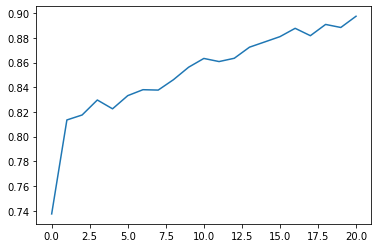

In [ ]:
plt.plot(model_history.history["accuracy"])

In [ ]:
def display(display_list):
    plt.figure(figsize=(20, 20))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
   
    plt.show()

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

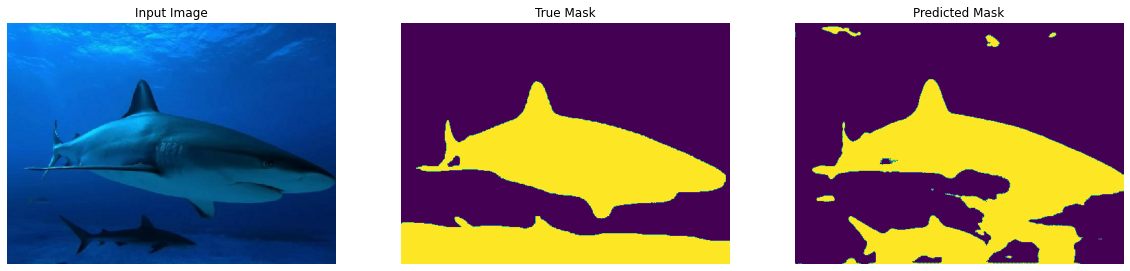

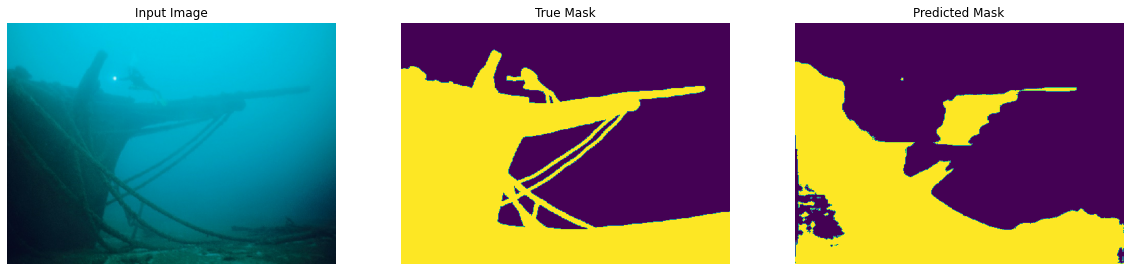

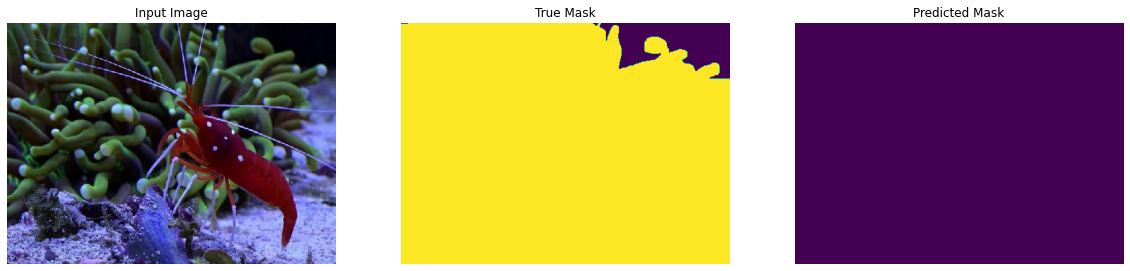

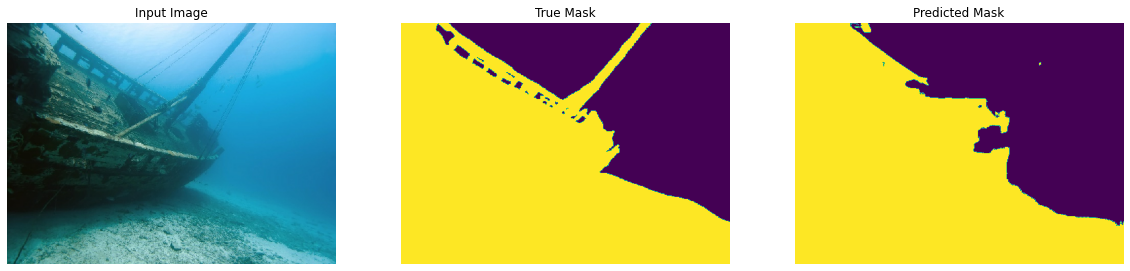

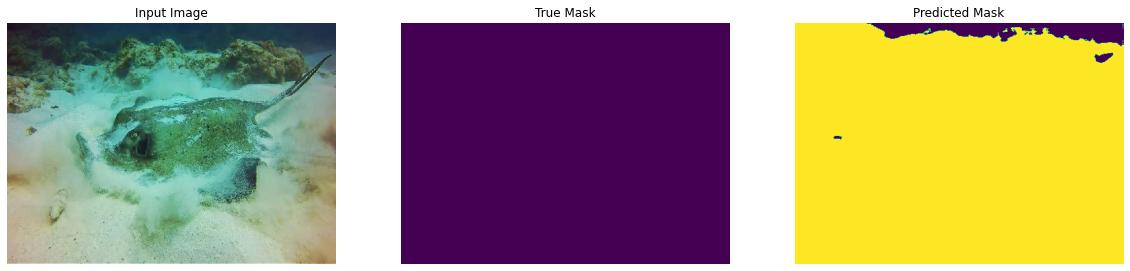

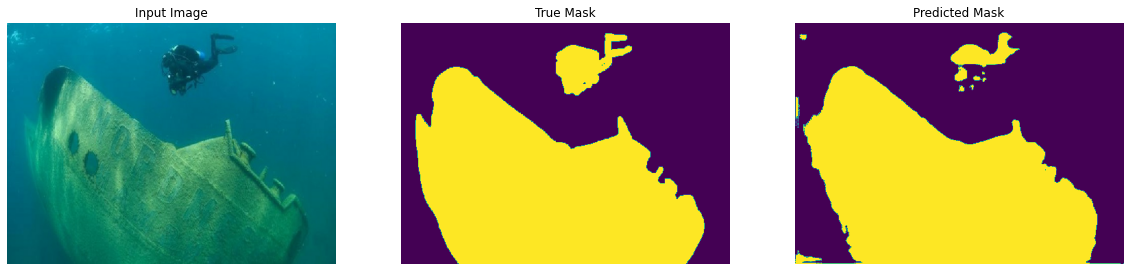

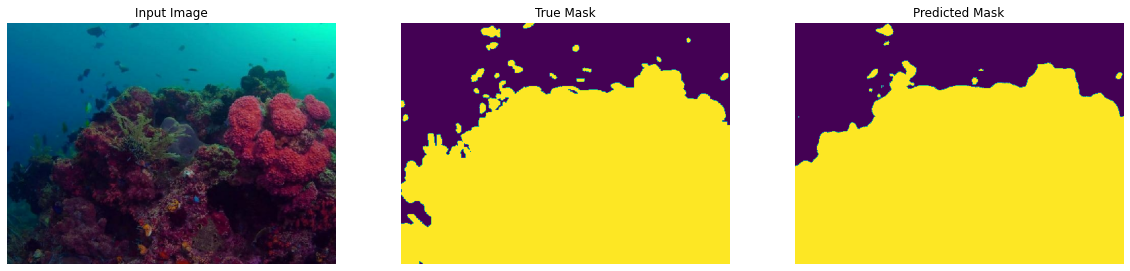

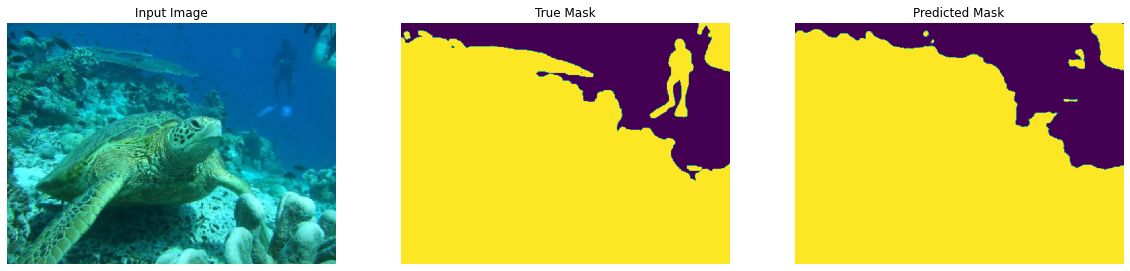

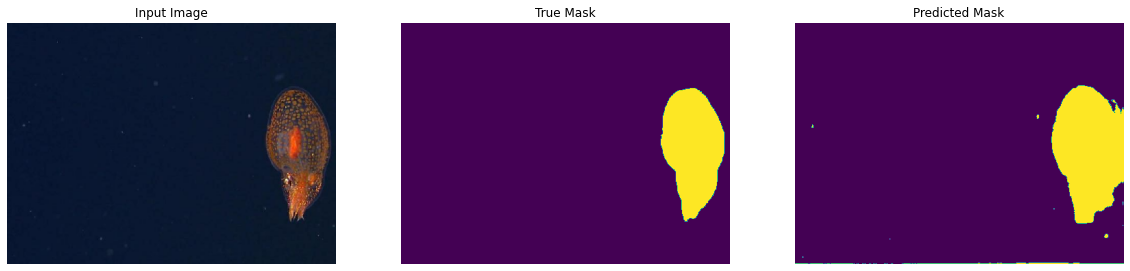

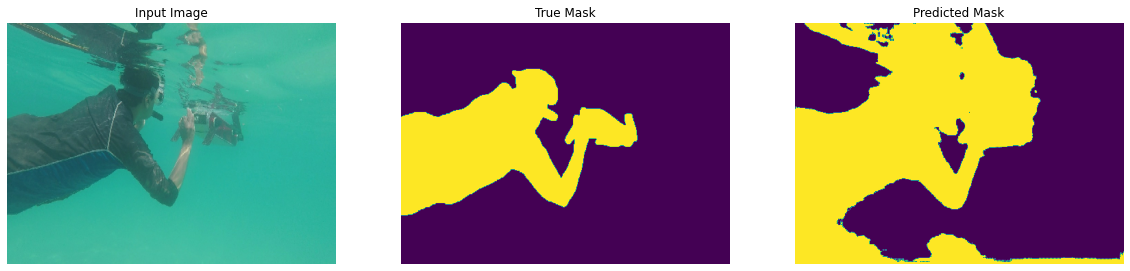

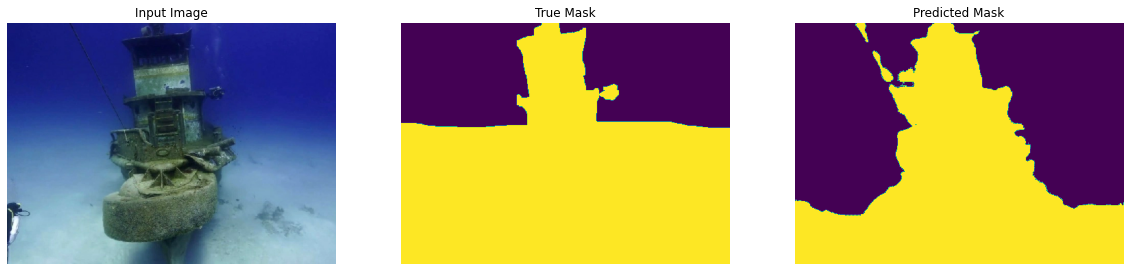

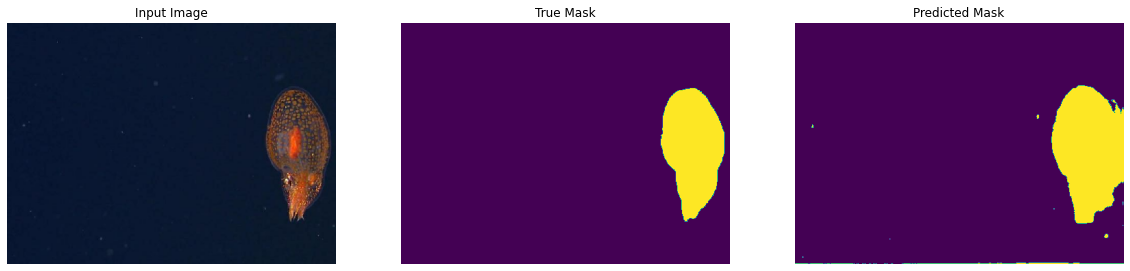

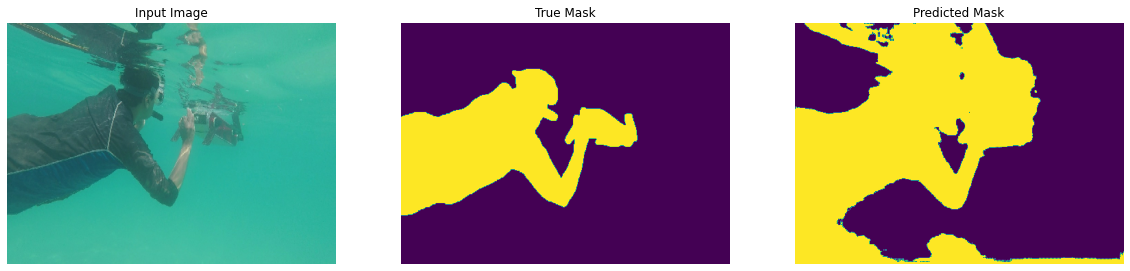

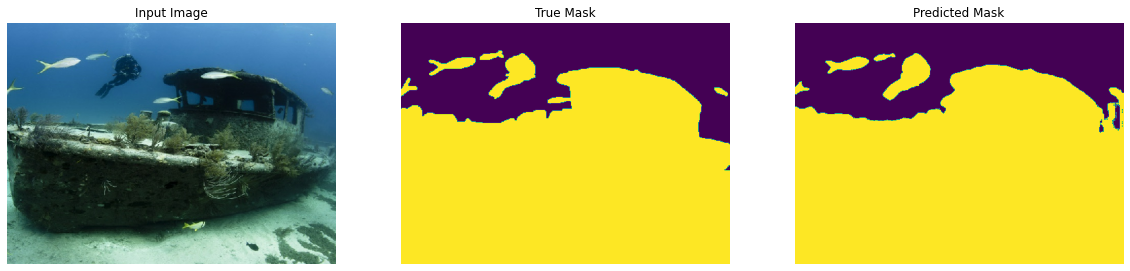

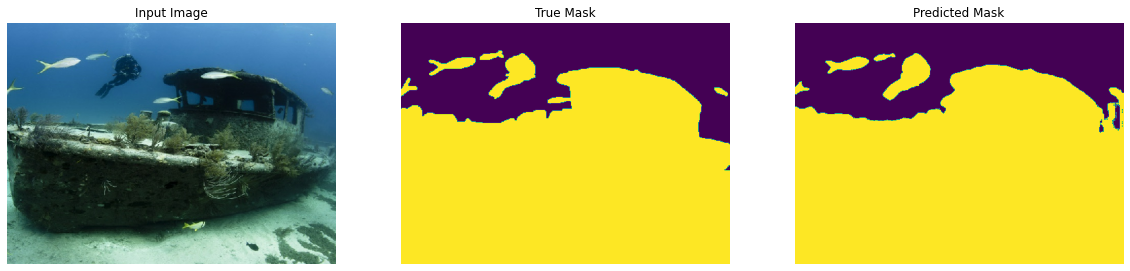

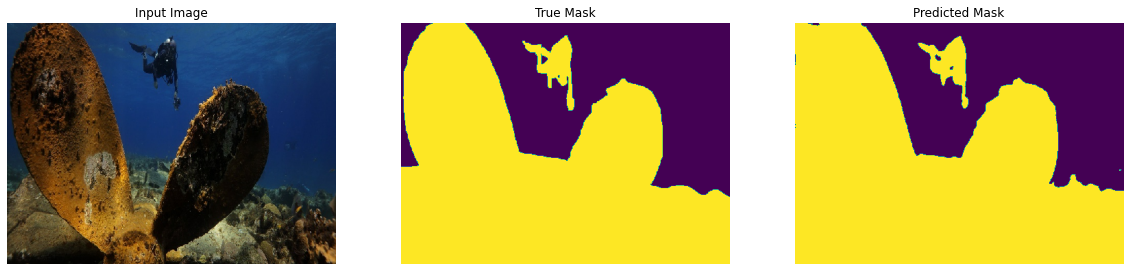

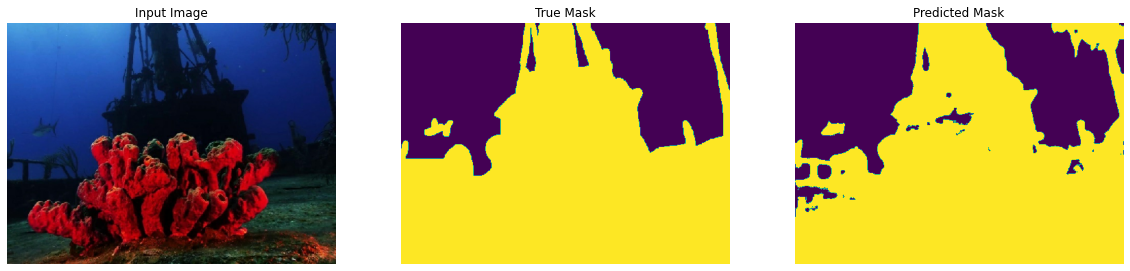

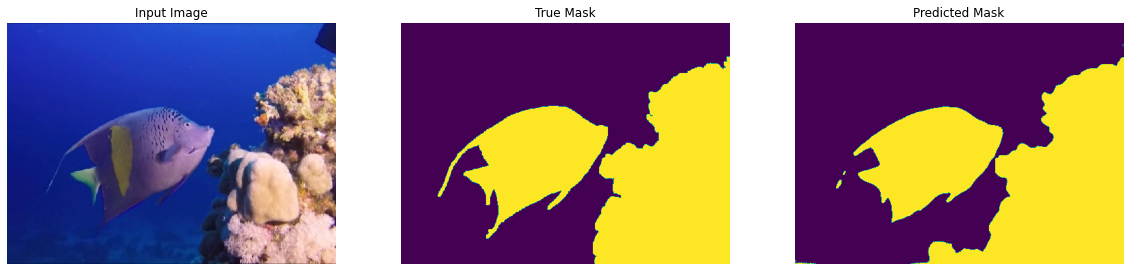

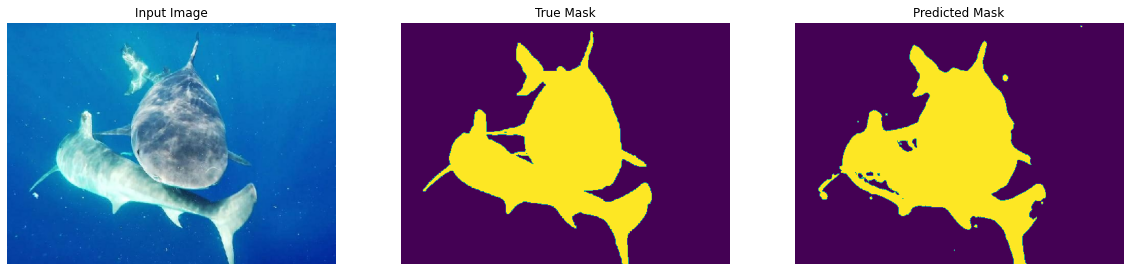

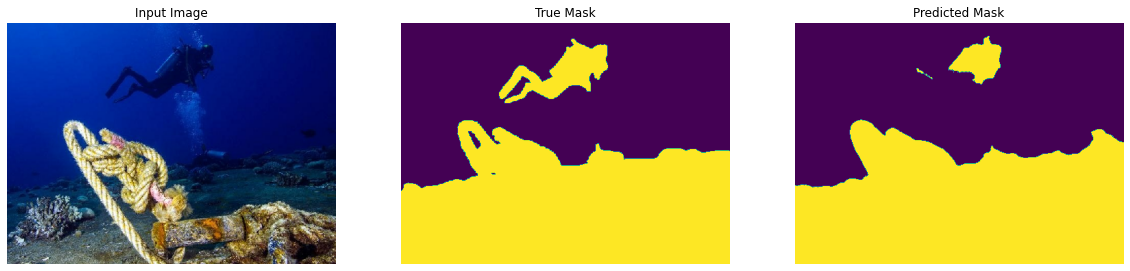

In [ ]:
for i in range(20):
    index = np.random.randint(test_images.shape[0])

    input_image = test_images[index]
    true_mask = test_masks[index]
    
    pred_mask = unet(tf.expand_dims(input_image, axis=0))
    pred_mask = create_mask(pred_mask)

    display([input_image, true_mask, pred_mask])

#**SAVE THE TRAINED MODEL**

In [ ]:
!mkdir -p saved_model
unet.save('saved_model/SUIM_3')

In [ ]:
!zip -r /content/SUIM_1.zip /content/saved_model/SUIM_1

  adding: content/saved_model/SUIM_1/ (stored 0%)
  adding: content/saved_model/SUIM_1/keras_metadata.pb (deflated 95%)
  adding: content/saved_model/SUIM_1/saved_model.pb (deflated 90%)
  adding: content/saved_model/SUIM_1/variables/ (stored 0%)
  adding: content/saved_model/SUIM_1/variables/variables.data-00000-of-00001 (deflated 6%)
  adding: content/saved_model/SUIM_1/variables/variables.index (deflated 77%)
  adding: content/saved_model/SUIM_1/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/SUIM_1.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>